<a href="https://colab.research.google.com/github/jarrodsb/DSPS_JBieber/blob/main/HW6/Second_Half_fitlinetogrbafterglow_mcmc_Bieber_dsps25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PHYS 461 - Homework 6 - Jarrod Bieber
---

# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods.

Notes:

    a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
    we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    

# initial imports

In [2]:
!pip install emcee # install the emcee package that implements the _affine invariant MCMC_ method

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 1.0 MB/s eta 0:00:00


In [3]:
!pip install corner

In [4]:
import pandas as pd
import pylab as pl
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import pylab as plt
# you will need more imports, put them here
import emcee
import corner

# HW part 1

## Read in the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

In [5]:
# data is called grb050525A.csv in the data folder in the DSPS_FBianco repo
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/DSPS_FBianco/refs/heads/main/data/grb050525A.csv")
grbAG.head()


,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


Text(0.5, 1.0, 'GRB Magnitudes vs Time')

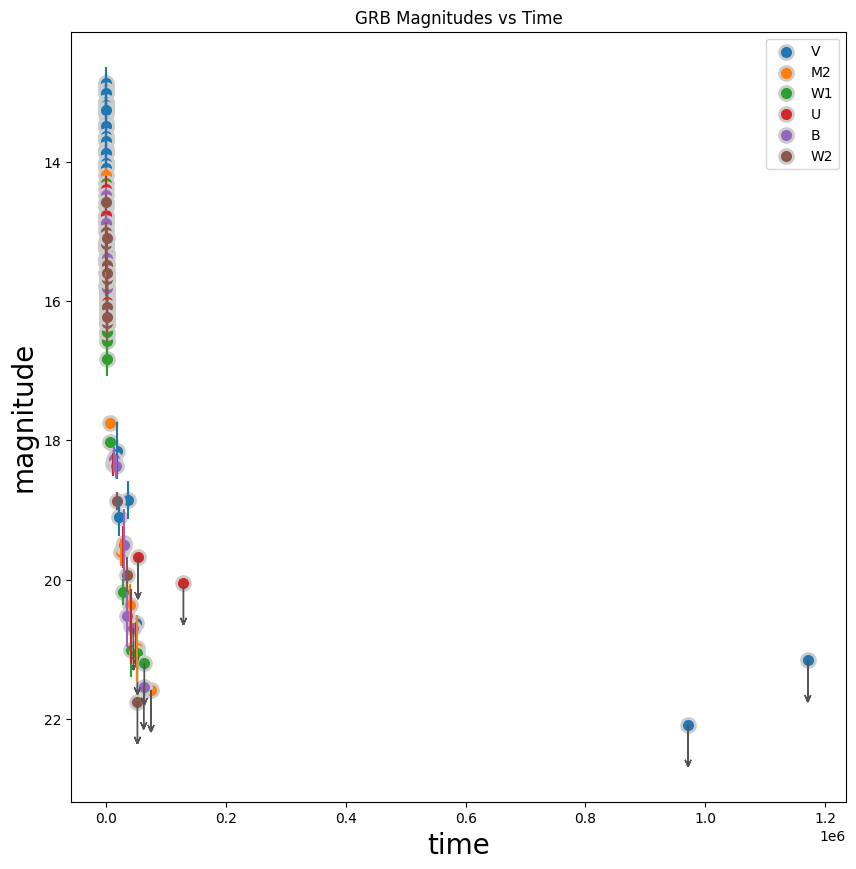

In [6]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)

#loop on every filter to plot - this will give differnt colors naturally.
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "time"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "time"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].time,
             grbAG.loc[i].mag, 0, 0.5, head_width=1e4,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
ax.yaxis.set_inverted(True)  # inverted axis with autoscaling
#pl.ylim(24,11.7) #simpler, less elegant - still does the trick
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("time", fontsize=20);
pl.title("GRB Magnitudes vs Time")

Figure 0: A plot of GRB afterglow brightness in terms of astronomical magnitude, versus time after the initial explosion that the signal was measured. The y axis is inverted, and the individual frequency bands are color coded and displayed in the legend. We can see that the brightness falls off quite rapidly, although there are some significant outliers in the data.

## Create the log-time variable

We will fit a line in log space. That corresponds to fitting a powerlaw y=x^a in natural space.


In [7]:
grbAG["logtime"] = np.log10(grbAG["time"])
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


## Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B.

The information about the photometric band is stored in the variable ```grbAG.filter```. Plot the data with different colors for different photometric bands.

In [8]:
def plotlogtime(df, models=[]):
  #create a figure container and an axis object inside of it
  ax = pl.figure(figsize=(10,10)).add_subplot(111)

  #loop on every filter to plot - this will give differnt colors naturally.
  #Use pl.errorbar to plot the uncertainties

  for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

  # replot to add a better marker (optional)
  for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


  # plot the upperlimits as arrows
  nuplim = grbAG.mag.isna().sum()
  for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime,
             grbAG.loc[i].mag, 0, 0.5, head_width=0.1,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

  # I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
  ax.yaxis.set_inverted(True)  # inverted axis with autoscaling
  pl.legend()

  #Always rememebr you axis labels!!
  pl.ylabel("magnitude", fontsize=20)
  pl.xlabel("log time", fontsize=20)
  pl.title("GRB Magnitudes vs Time")
  return ax

<Axes: title={'center': 'GRB Magnitudes vs Time'}, xlabel='log time', ylabel='magnitude'>

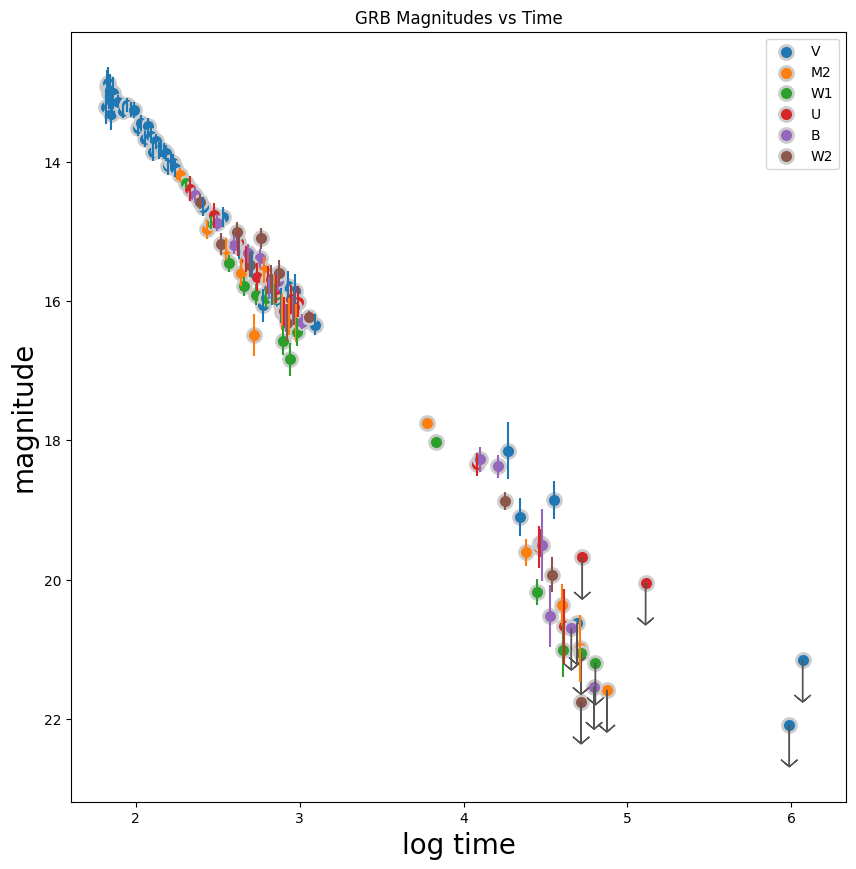

In [9]:
plotlogtime(grbAG)

Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows.

## Solve using the Normal Equation

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [10]:
grbAGnouplim =  grbAG[grbAG["upperlimit"] == 0]# remove the upper limits from the dataframe to simplify the analysis

In [11]:
x = grbAGnouplim.logtime.values
#pick a function to expand the axis
#option 1
X = np.c_[np.ones((len(grbAGnouplim), 1)),x]
#option 2 np.dstack((np.ones((X.shape[0])) ,X))


y = grbAGnouplim.mag.values
print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


In [12]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print ("best fit parameters from the Normal Equation: " +
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


## Fit a line to the data (excluding the upper limits) with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.

The information about whether the point is an upper limit or a measurement is stored in the variable ```grbAG.upperlimit```.
To remove the upper limits you can "broadcast" the data: in pandas that looks like

```grbAG.loc[grbAG.upperlimit == 0]```



In [13]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
lr = LinearRegression()
lr.fit(X, y)
print(f"slope {lr.coef_[1]:.2f} and intercept {lr.intercept_:.2f}")

slope 2.51 and intercept 8.58


## Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L1 and L2 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.


In [14]:
#note: imports should be moved to the top cell - follow PEP8 guidelines
from scipy.optimize import minimize

def line(intercept, slope, x):
    '''returns a line
    args:
    intercept: float
    slope: float
    x: array-like of exogenous variables
    '''
    return intercept + slope * x

def l1(args, x, y):
    '''l1 target function: returns value of l1 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L1 abs value of difference between prediction and data squared
    '''
    a, b = args
    return np.sum(np.abs(line(a, b, x) - y))


initialGuess = (2, 8)

l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " +
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 26.30332889501873
        x: [ 8.225e+00  2.641e+00]
      nit: 14
      jac: [-1.254e-01 -2.083e+00]
 hess_inv: [[ 2.054e-02 -4.529e-03]
            [-4.529e-03  1.001e-03]]
     nfev: 300
     njev: 96

best fit parameters from the minimization of L1: slope 8.23, intercept 2.64


In [15]:

def l2(args, x, y):
    '''l2 target function: returns value of l2 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L2 sum of difference between prediction and data squared
    '''
    a, b = args
    return np.sum((line(a, b, x) - y)**2)


initialGuess = (2, 8)

l2Solution = minimize(l2, initialGuess, args=(x, y))
print(l2Solution)
print("")
print("best fit parameters from the minimization of L2: " +
       "slope {:.2f}, intercept {:.2f}".format(*l2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 12.825987500725498
        x: [ 8.583e+00  2.512e+00]
      nit: 5
      jac: [-1.192e-07 -3.576e-07]
 hess_inv: [[ 6.254e-02 -2.030e-02]
            [-2.030e-02  7.114e-03]]
     nfev: 21
     njev: 7

best fit parameters from the minimization of L2: slope 8.58, intercept 2.51


In [16]:
#l2?

In [17]:
#l1?

## Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

In [18]:
def chi2(args, x, y, s):
    a, b = args
    return np.sum((line(a, b, x) - y)**2 / s**2)


x = grbAGnouplim.logtime.values
y = grbAGnouplim.mag.values
s = grbAGnouplim.magerr.values

initialGuess = 8, 2

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " +
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 317.4206698013056
        x: [ 8.599e+00  2.480e+00]
      nit: 7
      jac: [-1.907e-05 -1.526e-05]
 hess_inv: [[ 3.314e-03 -2.853e-03]
            [-2.853e-03  2.473e-03]]
     nfev: 125
     njev: 38

best fit parameters from the minimization of the chi squared: slope 8.60, intercept 2.48


## Plot all the solutions

Create a function that uses the parameters you input and plots a line. Add a legend that describes which line corresponds to what.


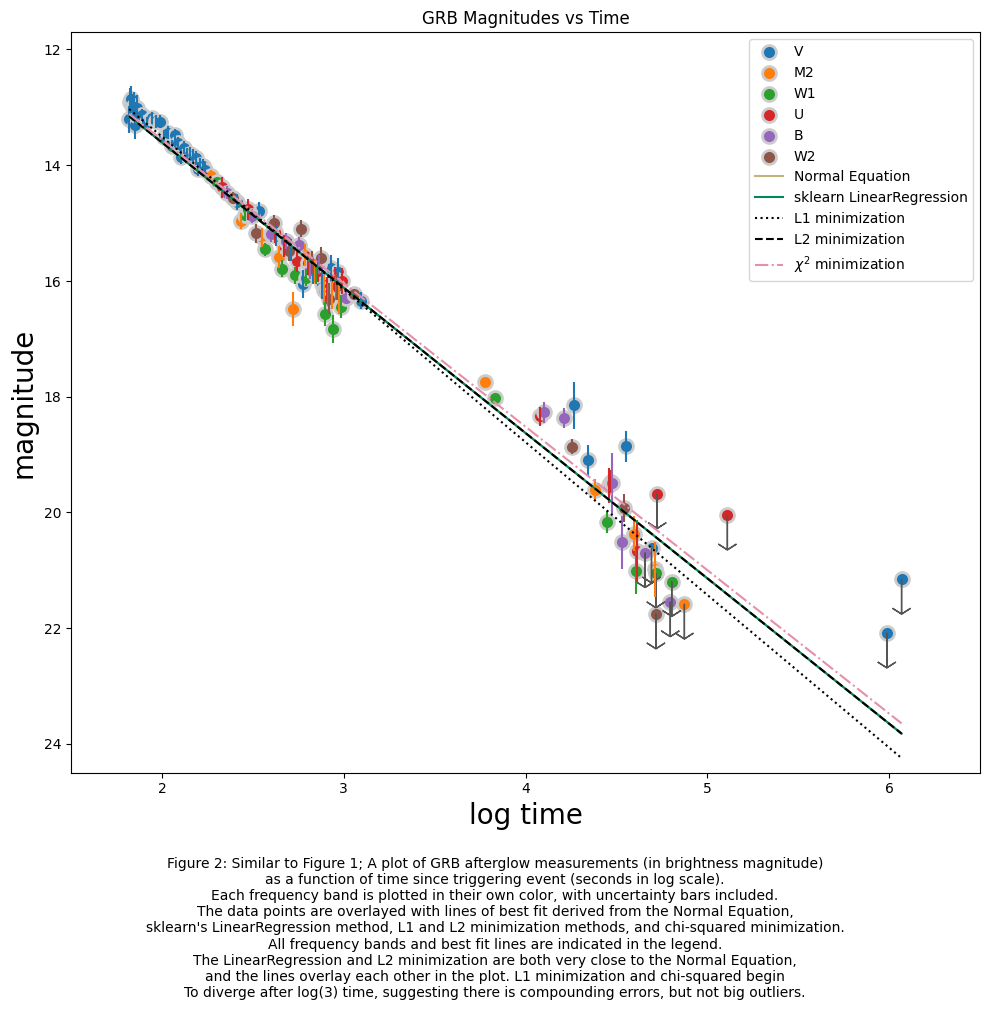

In [19]:
def plotline(pars, x, color='k', symbol='-', label='model',
             alpha=1, ax=ax):
    slope, intercept = pars
    y = line(intercept, slope, x)
    ax.plot(x, y, ls=symbol, c=color, label=label, alpha=alpha)


ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]
#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],
         label="Normal Equation", ax=ax)

#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)

#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':',
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--',
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.',
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

caption = """Figure 2: Similar to Figure 1; A plot of GRB afterglow measurements (in brightness magnitude)
as a function of time since triggering event (seconds in log scale).
Each frequency band is plotted in their own color, with uncertainty bars included.
The data points are overlayed with lines of best fit derived from the Normal Equation,
sklearn's LinearRegression method, L1 and L2 minimization methods, and chi-squared minimization.
All frequency bands and best fit lines are indicated in the legend.
The LinearRegression and L2 minimization are both very close to the Normal Equation,
and the lines overlay each other in the plot. L1 minimization and chi-squared begin
To diverge after log(3) time, suggesting there is compounding errors, but not big outliers."""

pl.figtext(0.5, 0.00, caption, ha='center', fontsize=10, wrap=True)
plt.tight_layout(rect=[0, 0.15, 1, 1])


# RERWITE THIS CAPTION!   (Bieber - I rewrote the caption.)

# HW part 2: redo the sklearn model with a train-test split of the data

- choose the train-test rations that you prefer
- get the score for the model when predicting on the train data and on the test data
- what can you say about the model by comparing the two scores?

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((91, 2), (91,), (17, 2), (17,))

In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)
print(f"score on the training set {lr.score(X_train, y_train):.2f}")
print(f"score on the training set {lr.score(X_test, y_test):.2f}")

score on the training set 0.97
score on the training set 0.95


The score is the same for the training and test set. This means that we are not overfitting the data and the model is transferable to unseen data. Furthermore the score is high: the model explains 97% of the variance which is remarkably good!

# Now try a line to the data with MCMC

# HW part 3: write captions for each figure. The figures are produced by my code. The captions should state:
- what is plotted
- what is noticeable or interesting in the figure



In [22]:
!pip install emcee # install the emcee package that implements the _affine invariant MCMC_ method

In [23]:
import emcee #import the package - please move this to the top with the other imports!

In [24]:
emcee

<module 'emcee' from '/usr/local/lib/python3.12/dist-packages/emcee/__init__.py'>

look at documentation: https://emcee.readthedocs.io/en/stable/

We are implementing Bayes theorem to find the best model parameters:

$P(\theta | D) ~ P(D | \theta) * P(\theta)$

or

_Posterior ~ Likelihood * Prior_

Since we are maximizing the likelihood, we work in log space because:
- the logarithm is a monotonic function of its argument (meaning where the argument gets bigger its log gets bigger, where it gets smaller its log gets smaller)
- the log is not defined for negative values (log(something < 0) is undefined) but this does not matter because the likelihood is a probability and probabilities are positive defined.



# Below i develop the line model and find the posterior with MCMC. Your task is to do the same for a different model. the Broken Power Law

In [25]:
# LINE MODEL
def log_prior(theta):
  slope, intercept = theta
  if slope > 0 and intercept > 0:
    return 0
  #semi informative prior: i know light has to get fainter (mag get bigger)
  #i know i dont use negative mags
  return -np.inf


In [26]:
#log likelihood
def log_likelihood(theta, x, y, yerr):
  slope, intercept = theta
  #chi2 likelihood : (data-model)**2 / uncertainty **2
  return -np.sum(((y - line(intercept, slope, x))**2) / yerr**2)

In [27]:
#log posterior
def log_posterior(theta, x, y, yerr):
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp + log_likelihood(theta, x, y, yerr)

In [28]:
#initial guess
ig = [1,10]

In [29]:
#initialize N walkers
nwalkers = 32
ndim = len(ig)

In [30]:
#the starting point for each walker is a small perturbation of the initial guess
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim)

In [31]:
pos.shape

(32, 2)

In [32]:
# this sets up the model and assignes the hyperparameters
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, s))

In [33]:
# this runs the MCMC for 5,000 steps
sampler.run_mcmc(pos, 1_000, progress=True); #progress=True show the dynamic percentage bar

100%|██████████| 1000/1000 [00:01<00:00, 531.48it/s]


In [34]:
# this extracts the ergodic markovian chains of positions in the feature space
samples = sampler.get_chain()

In [35]:
samples.shape

(1000, 32, 2)

In [36]:
samples.transpose(1,0,2)[:,:,0].shape

(32, 1000)

Text(0.5, 1.0, 'MCMC random walk')

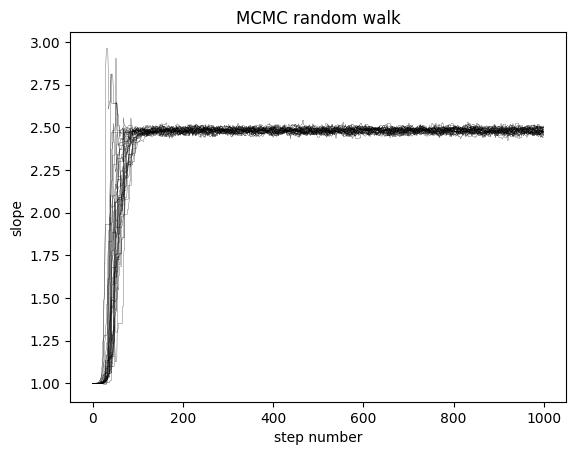

In [37]:
for i in range(ndim):
    pl.plot(samples[:,:,0], 'k', lw=0.1, )
plt.xlabel("step number")
plt.ylabel("slope")
plt.title("MCMC random walk")

Figure 3: A plot of a MCMC random walk chain, that starts off crazy (AKA burn in), then converges to around 2.5 for the slope. It only takes about 100 steps before rapidly converging. Wow!

to get statistical properties of the chains I will concatenate the 32 chains.
This works _iff_ the chains are independent - see about it in the slides!

note: the chains are _assumed_ to be independent


the first 100 points are where the chains are "burning in" and we will throw them away (`discard=100`) - see slides!!
`flat=True` does the concatenation


In [38]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

#the result of the mcmc (the best parameters and their uncertainties) are statistical properties of the chains
# I recommand the median and percentiles over the mean and standard deviation, since the chains need not be gaussian


In [39]:
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile(flat_samples[:,i], [16, 50, 84])

print(f"slope {mcmc[0][1]:.2f} [{mcmc[0][0]:.2f}-{mcmc[0][2]:.2f}]")
print(f"intercept {mcmc[1][1]:.2f} [{mcmc[1][0]:.2f}-{mcmc[1][2]:.2f}]")

slope 2.48 [2.47-2.49]
intercept 8.60 [8.56-8.64]


plotting the likelihood space: the panels are 2D projections of the feature space and 1D marginalized probabilities for each parameters


In [40]:
!pip install corner


Text(0.5, 1.02, 'Corner plot for MCMC Line Optimization')

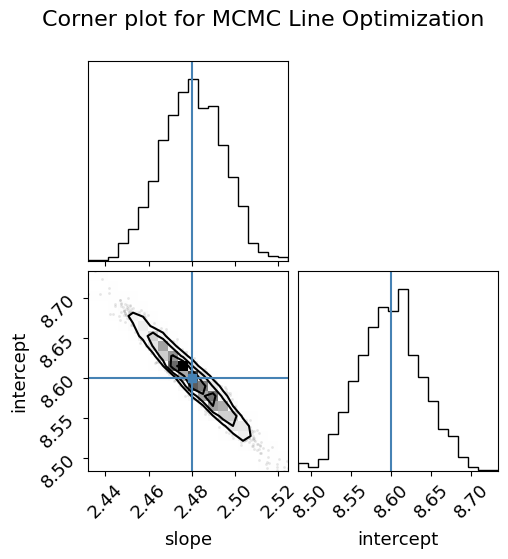

In [41]:
import corner
pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["slope", "intercept"], truths=mcmc[:,1]);

fig.suptitle("Corner plot for MCMC Line Optimization", y=1.02, fontsize=16)


WRITE YOUR OWN CAPTION HERE!

Figure 4: A corner plot, AKA a triangle plot that visualizes the results of the MCMC simulation. The diagonal plots show the posterior distribution for the slope and the intercept parameters individually, and then the central (off diagonal) plot shows the joint posterior distribution for slope/intercept pair. The points in this panel form an elongated shape, which indicates a correlation between slope and intercept. The elongation is sloping downwards, which tells us that this correlation is negative.

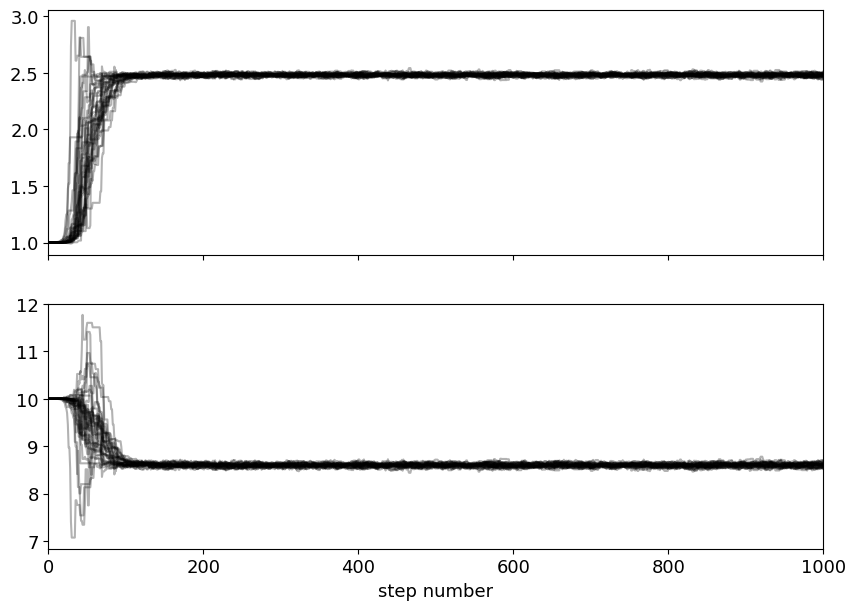

In [42]:
# the chains should be plotted as well. here is a better plot of the chains
#in the slides and in class I discussed what you should expect them to look like
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Figure 5: An example of the MCMC random walk chains to identify both the slope and intercept best fit parameters. Both walks last for 1,000 steps, but converge after only about 100 steps.

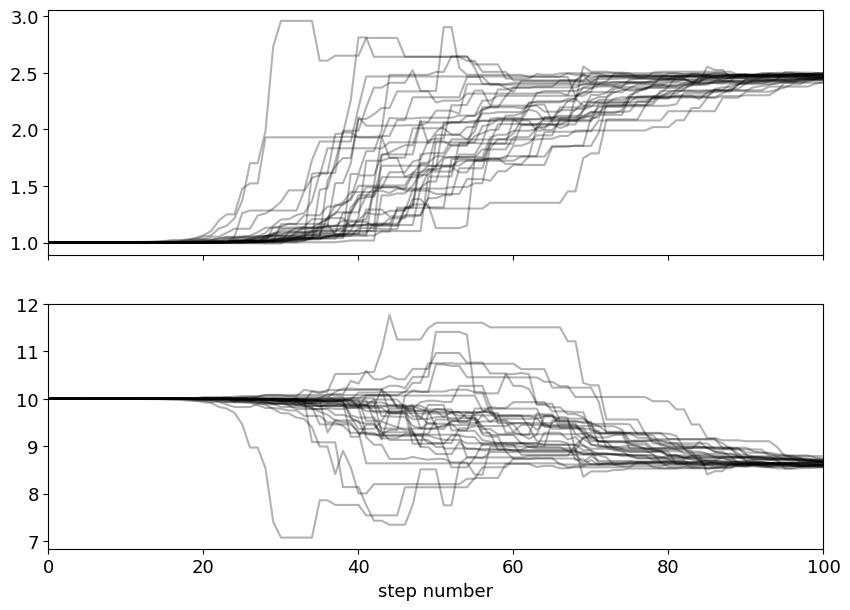

In [43]:
# zoom in: the beginnign of the chane should be cut - this is the burn-in part of the chain
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 100)#len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Figure 6: A zoomed-in view of the first 100 steps of the MCMC random walk chains from Figure 5. We indeed see the jumps from our initial guesses to a converged value, after only about 100 steps.

In [44]:
# save the mcmc results for later
mcmc_line = mcmc
mcmc_line

array([[2.46560776, 2.48016989, 2.49449512],
       [8.56044162, 8.59965775, 8.64039909]])

Text(0.5, 1.0, 'GRB Afterglows with Line Fit')

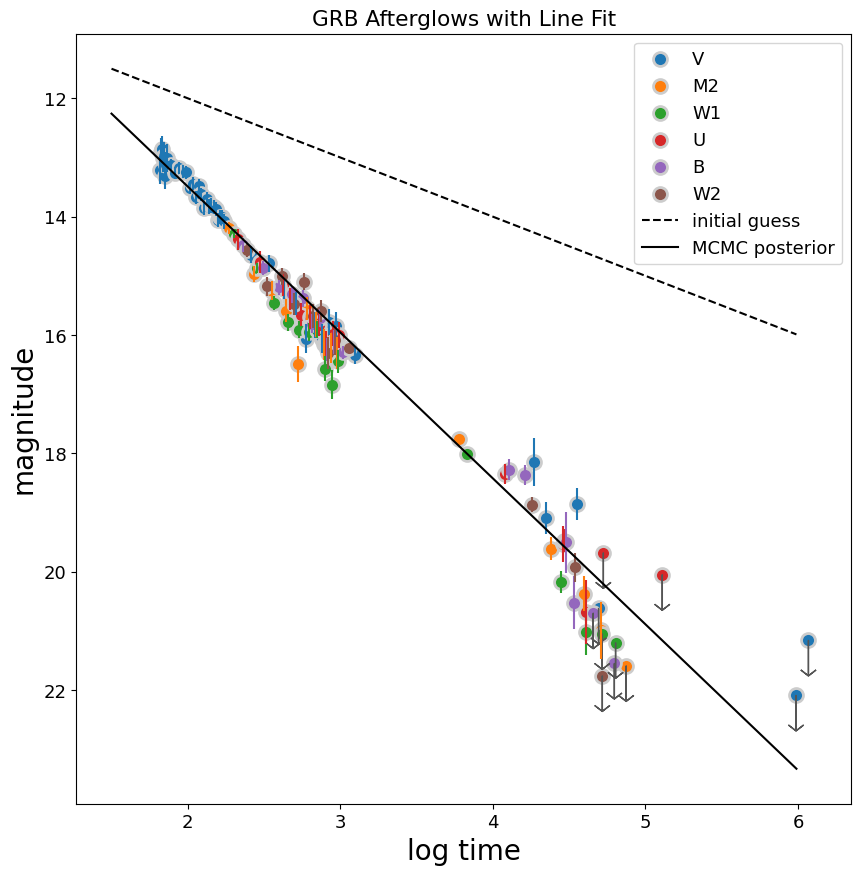

In [45]:
labels = ["intercept","slope"]
ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

ax.plot(np.arange(1.5,6,0.01),
        line(10, 1, (np.arange(1.5,6,0.01))),
        #line(ig[1], ig[0], 10**np.arange(1.5,6,0.01)),
        ls="--", c="k",
        label="initial guess")

ax.plot(np.arange(1.5,6,0.01),
        line(mcmc_line[1][0], mcmc_line[0][0], np.arange(1.5,6,0.01)),
        ls="-", c="k",
        label="MCMC posterior")

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

#pl.ylim(24.5,11.7)
#pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);
pl.title("GRB Afterglows with Line Fit")

Figure 7: A plot of our GRB afterglow photometric points (magnitude vs log time) from Figure 1, but with the MCMC-derived posterior overlayed, as well as our initial guess. All frequency bands are again included in the legend, as are the fit lines. We can see that the MCMC fitting was successfully able to recover from what turned out to be a pretty bad initial guess.

# HW part 3

# Now try a broken power law (BPL) model

A power la is not a good model for GRB afterglows. A broken power law has been known to be a better model and has several physical motivations. In this exercise you will fit a _broke power law_ to the data, which is a more complex and higher dimensional model than the simple line fit we did so far, with MCMC getting best values for the posterior, a complete characterization of the likelihood, and allowing model selection between the line and the power law.

> Here is some info that talks about the power law model and the phsyics of GRB, which you need not know to solve the assignment but you may be interested in.  A broken power law is a power law ($y ~ x^a$) where the power a changes at some point. This can be caused by the presence of two power law processes with different, for example, where one dominates at early time and the other at late times.


>> Here is some more info that explains why we observed the GRB afterglows as broken power laws.
>>Gamma-ray bursts (GRBs) are produced by the collapse of massive stars or the merger of compact objects like neutron stars. The energy of the collapse is highly energetic (Gamma rays) but the emission gets reprocessed as it leaves the system and looses energy becoming detectable in the optical wavelengths. This is called the "optical afterglow of the GRB".
>>The explosion resulting from the collapse generates a highly relativistic outflow of material that moves at a significant fraction of the speed of light.
>> The afterglow emission is primarily produced through synchrotron radiation, where charged particles spiral around magnetic field lines. The radiation produced by synchrotrone follows a power law with an index that depends on the density of the surrounding medium, the Lorentz factor of the outflow, and the magnetic field strength. As the radiation crosses different regions of the system that collapsed these factors change and the powerlaw index changes with them.

>>If the relativistic outflow is highly collimated (a jet) as the jet expands, its emission can be modeled as a power-law light curve, but  where the jet begins to decelerate and spread out the slope of the power law changes. This transition is known as the "jet break" and results in a broken power-law behavior.

>> Some GRBs exhibit late-time flares or additional energy injection from the central engine but we are not modeling this in this exercise.




_BPL model variables:_

$F = \mathrm{flux}$ - note: not magnitude this time! $mag ~ -2.5log10(Flux)$

$t =  \mathrm{time}$ - note: not log time

_BPL model parameters:_


$T_b =  \mathrm{Time~of~break}$

$a_1:  \mathrm{Early~slope}$

$a_2: \mathrm{Late~slope}$

$b:  \mathrm{nuisance~parameters}$

_BPL model_:

in flux space the BPL model is:
$F=\frac{F_0}{ \frac{t}{T_b}^{-a1} + \frac{t}{T_b}^{-a2}}$

in magnitude space (the data you want to predict is in magnitude and the equation is simple to minimize in log space) that is:

$mag = b - log_{10}\left((\frac{t}{T_b})^{-a1} + (\frac{t}{T_b})^{-a2})\right) $



In [46]:
# NOTE: this model is not in log time!!
t = grbAGnouplim.time.values

In [47]:
t.min(), t.max()

(np.int64(66), np.int64(51257))

# HW part 3 task 1:
create the model `bpl()`, the `log_likelihood()`, `log_prior()` (choose what you want to set your prior to), and `log_posterior()`

In [48]:
def bpl (theta, t):
    """broken power law model
    Input:
      theta: (array like) 4 parameters vector [Tb, a1, a2, b]
      t: (array like) independent variable (linear time)
    Return:
      model predictions for each t in magnitude space (array like)
    """
    # tb and t are linear times
     #a1, a2, Tb, b = theta
    tb, a1, a2, b = theta
    # Use the provided formula for magnitude
    return b - np.log10(((t/tb)**(-a1) + (t/tb)**(-a2)))

In [49]:
def log_likelihood_bpl(theta, x, y, yerr):
  # use the same log_likelihood as before (chi2) but with the new model
  #theta is [Tb, a1, a2, b]
  #t is linear time
  #y is magnitude data
  #yerr is magnitude error
  #print(f"Testing parameters: Tb={theta[0]}, a1={theta[1]}, a2={theta[2]}, b={theta[3]}") # Add this print statement
  #chi2 likelihood : (data-model)**2 / uncertainty **2
  return -0.5 * np.sum(((y - bpl(theta, x))**2) / yerr**2)


def log_prior_bpl(theta):
  # similar to before, but choose relevant regions of avoidance based on the description of the model
  tb, a1, a2, b = theta
  # Priors: Tb is within data range, slopes are positive, b is reasonable magnitude offset
  if 50 < tb < 60000 and a1 > 0 and a2 > 0 and 10 < b < 25:
      return 0.0
  return -np.inf


def log_posterior_bpl(theta, x, y, yerr):
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  lp_bpl = log_prior_bpl(theta)
  if not np.isfinite(lp_bpl):
    return -np.inf
  return lp_bpl + log_likelihood_bpl(theta, x, y, yerr)

# HW part 3 task 2:
Find the initial starting point as a stochastic gradient descent minimization of the log likelihood

In [50]:
ig = [1000, 0.005, 0.0025, 12] # Changed from order [a1, a2, Tb, b] to [Tb, a1, a2, b]. Changed guess from the original [1000, 0.2, 5, 20].
#what does the minimize function need to take as arguments?
# Add bounds to the minimization
#bounds = [(50, 60000), (0, 0.1), (0, 0.1), (10, 25)]


# FBB define something like nll = lambda *args: -log_likelihood_bpl(*args) and do minimize of nll instead - no bounds needed
nll = lambda *args: -log_likelihood_bpl(*args)

#soln = minimize(log_likelihood_bpl, ig, args=(t, y, s), bounds=bounds)
soln = minimize(nll, ig, args=(t, y, s))
print(soln)
print("")
print("best fit parameters from the minimization of chi2: " +
       "time of break {:.2f},  early slope {:.2f}, late slope {:.2f}, intercept {:.2f}".format(*soln.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 108.7326572775876
        x: [ 2.736e+02  2.146e+00  3.548e+00  1.505e+01]
      nit: 76
      jac: [ 1.526e-05  9.537e-07  1.526e-05  1.049e-05]
 hess_inv: [[ 2.444e-04 -1.850e-04  1.290e-03  3.299e-04]
            [-1.850e-04  3.416e-03 -1.081e-02 -3.488e-03]
            [ 1.290e-03 -1.081e-02  3.655e-02  1.166e-02]
            [ 3.299e-04 -3.488e-03  1.166e-02  3.913e-03]]
     nfev: 1054
     njev: 208

best fit parameters from the minimization of chi2: time of break 273.58,  early slope 2.15, late slope 3.55, intercept 15.05


Text(0.5, 1.0, 'GRB Afterglows with BPL Fit')

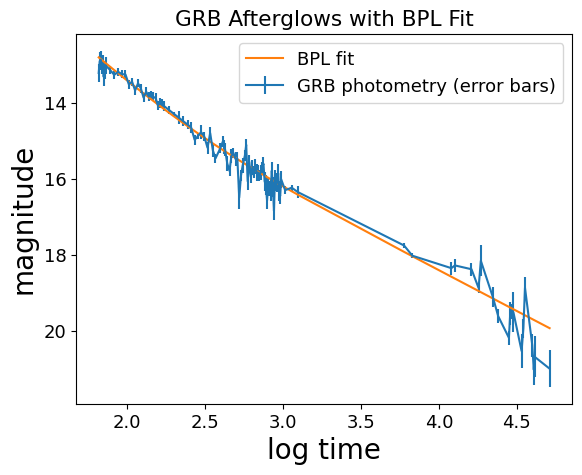

In [51]:
ig = soln.x # the initial guess for the MCMC

# plot the model as it looks with the initial guess values
pl.errorbar(x, y, yerr=s, label="GRB photometry (error bars)")
#pl.plot(x, bpl(ig, x_nolog))
pl.plot(x, bpl(ig, t), label="BPL fit")
pl.legend()
pl.xscale("linear")

ax = pl.gca()
ax.yaxis.set_inverted(True)  # inverted axis with autoscaling
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20)
plt.title("GRB Afterglows with BPL Fit")


Figure 8: A plot of the error bars of our GRB afterglow data, overlayed with a broken power law fit determined by a stochastic gradient descent minimization. The minimization is based on the following initial guess: Time of Break = 1,000, a1 slope = 0.005, a2 slope = 0.0025, b = 12. The minimized values turned out to be Tb = 273.85, a1 = 2.15, a2 = 3.55, b = 15.05. The implication from the plot is that 273.85 seconds after a GRB explosion, some other physical proecess dominates the afterglow, and changes the brightness to fall off more gradually.

# HW 3 task 3: optimize the model wit MCMC

- set the emcee hyperparameters
- run the chains
- extract the statistical properties of the chain as the best fit values
- plot the model
- plot the marginalized posteriors of the model parameters

In [52]:
# set the emcee hyperparameters
#ig = [1000, 0.005, 0.0025, 12]
ig = [273, 2.15, 3.55, 15.05]  # Using the best fit parameters from the chi2 minimization

#initialize N walkers
nwalkers = 32
ndim = len(ig)

#the starting point for each walker is a small perturbation of the initial guess
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim)


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_bpl, args=(t, y, s))

In [53]:
# run the model
# this runs the MCMC for 1,000 steps
sampler.run_mcmc(pos, 1_000, progress=True); #progress=True show the dynamic percentage bar

100%|██████████| 1000/1000 [00:05<00:00, 198.04it/s]


Text(0.5, 1.0, 'MCMC random walk')

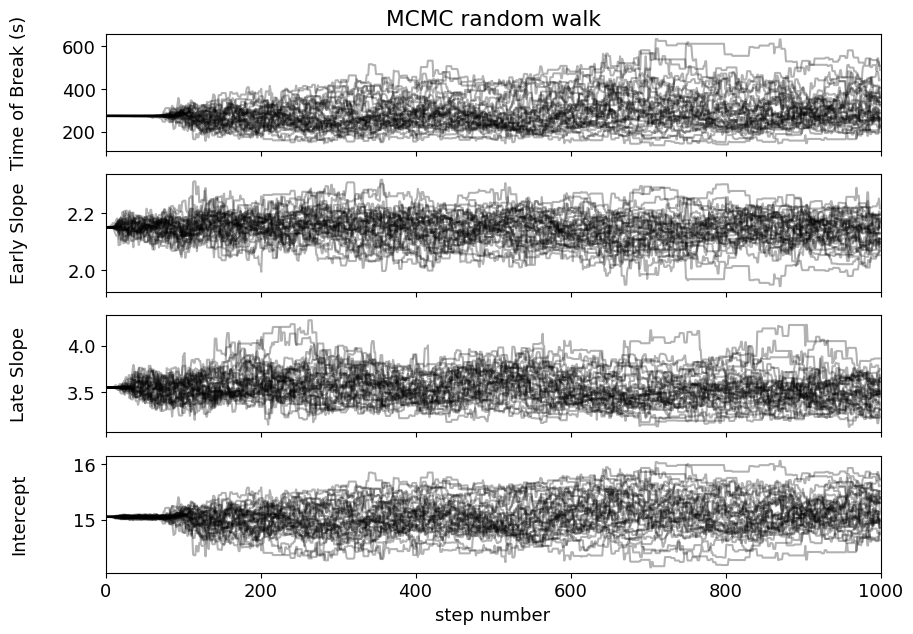

In [54]:
#plot the chains
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

axes[0].set_ylabel("Time of Break (s)")
axes[1].set_ylabel("Early Slope")
axes[2].set_ylabel("Late Slope")
axes[3].set_ylabel("Intercept")

axes[0].set_title("MCMC random walk")


Figure 9: The 1,000-step MCMC random walk chains for the BPL parameters: time of break, early slope, late slope, and intercept value. Each chain starts with an initial guess that is informed by the result of the minimization procedure. It then proceeds to explore the parameter space around these guessed values, sticking to the areas of highest probability. After 1000 steps, the MCMC doesn't stray too far from the guesses, suggesting that the minimization results were accurate. The degree of spread indicates a level of uncertainty with respect to each of the BPL parameters.

In [55]:
# get the 16th, 50, and 84th percentiles of the model parameters
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
    mcmc[i] = np.percentile(flat_samples[:, i], [16, 50, 84])
mcmc[:,1]

array([273.28797468,   2.14869306,   3.52783277,  15.04470749])

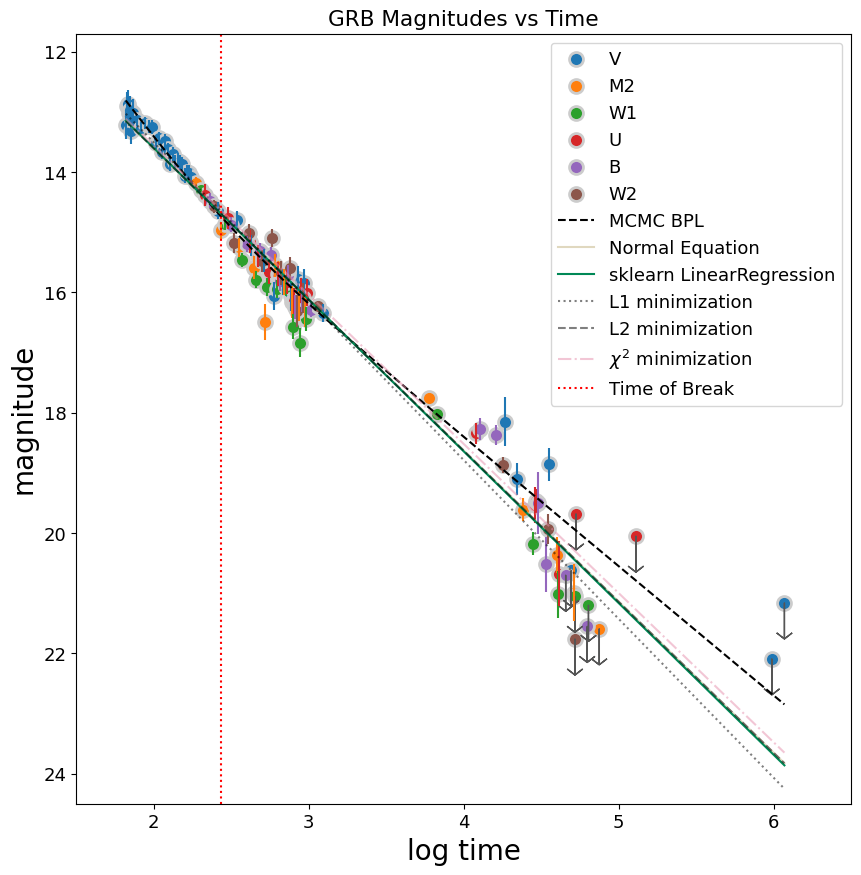

In [64]:
#plot the model
ax = plotlogtime(grbAG)
#ax = pl.figure(figsize=(10,10)).add_subplot(111)

#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

# Plot the broken power law MCMC model
ax.plot(grbAG.logtime.values, bpl(mcmc[:,1], grbAG.time.values), ls="--", c="k", label="MCMC BPL")


#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],  alpha=0.5,
         label="Normal Equation", ax=ax)
#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)
#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':', alpha=0.5,
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--', alpha=0.5,
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.', alpha=0.5,
         label=r"$\chi^2$ minimization", ax=ax)

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')
pl.axvline(np.log10(mcmc[0,1]), color='r', linestyle=':', label='Time of Break') # Add vertical line at the time of break
pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);
pl.legend()

Figure 10: Another plot of our GRB data, with the overlayed best fit lines from the various optimization methods. This time, our MCMC optimization is included, represented as black dashed lines in the legend. We can see that the MCMC fit, which uses a BPL model, has a shift in the slope at the Time of Break, at around 272.7 seconds. The Time of Break is represented as a vertical red dotted line in the plot. We can see that particularly at earlier times before the Time of Break, the MCMC fit is most accurately fitting the data. At later times, after the Time of Break, the BPL MCMC fit strays upward, away from all of the straight line fits. It becomes closer to some bright upper limit points at later times, but further away from a dimmer cluster of data points that occur between log times 4 and 5. This suggests to me that the BPL model is better, but still not an ideal fit for the data.

## plot the marginalized posterior distributions of the parameters

Text(0.5, 1.02, 'Marginalized Posterior Distributions for BPL Model Parameters')

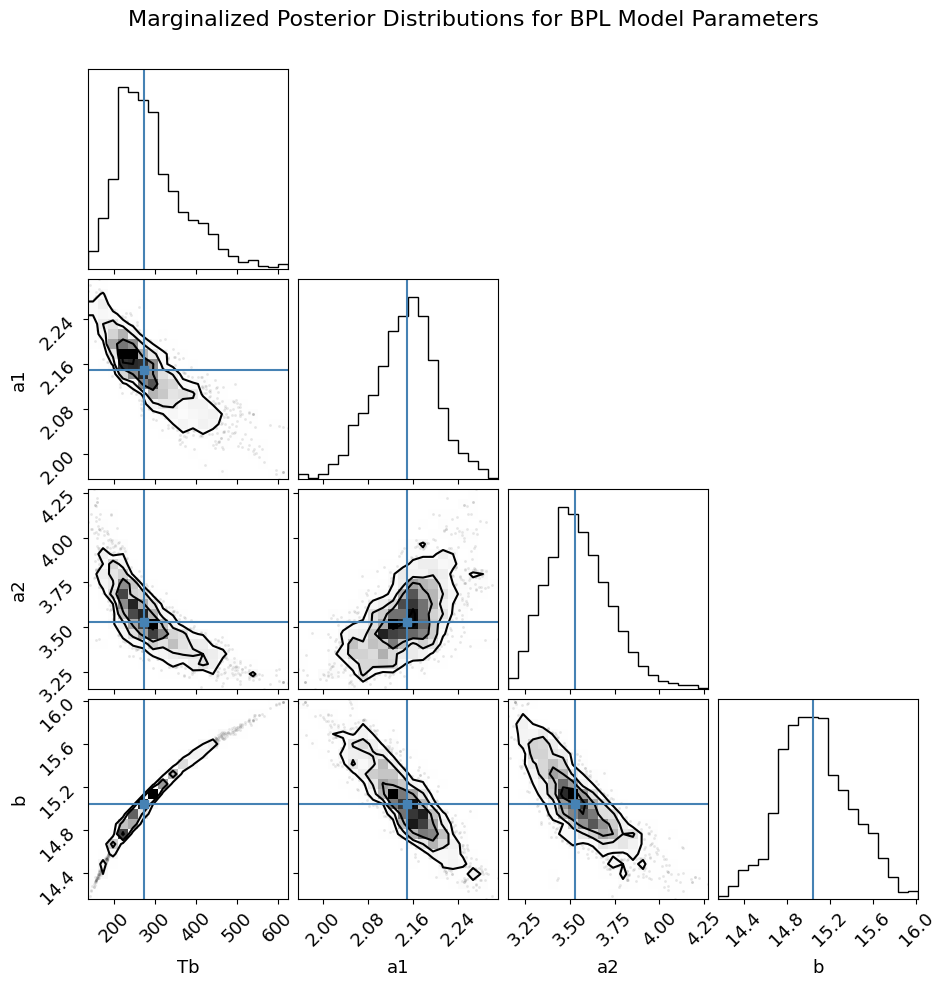

In [57]:
pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=[ "Tb", "a1", "a2", "b"], truths=mcmc[:,1]);

fig.suptitle("Marginalized Posterior Distributions for BPL Model Parameters", y=1.02, fontsize=16)

Figure 11: A corner plot deoicting the marginalized posterior distributions for BPL model parameters (Tb, a1, a2, and b). The diagonal panels show the probability distributions for each parameter individually. The peak of each histogram indicates the most probable value for that parameter, and the spread of the histogram represents the uncertainty. The vertical lines indicate the median of the distribution. The off-diagonal panels show the probability distributions for pairs of parameters. The clear elongated shape in the plots reveal the correlations between parameters. The direction of the elongation in the Tb / b and a1 / a2 panels tell us that these correlations are positive, while the direction in the remaining panels tells us that the correlation for those other parameter pairs is negative.

EXTRA CREDIT FOR 461 REQUIRED FOR 661   (**JB - I am in 461, so this should be extra credit for me** 😉)

# HW part 4: Compare the line (as obtained by the MCMC) and broken power law models. For this part of the assignment use the slides in https://slides.com/d/Ql12kB4/live#/11. in particular:

- Print the loglikelihood of each model (you can use the log_likelihood function you had written for each)


- implement the calculation of the likelihood ration, which is expected to be chisq distributed following a chisq distribution with k degrees of freedom where k is the difference in number of parameters.

- implement the caluculation of the AIC (https://slides.com/d/Ql12kB4/live#/11/6
- and BIC (https://slides.com/d/Ql12kB4/live#/11/8)



In [58]:
print(f"Log-likelihood of the line model: {log_likelihood(mcmc_line[:,1], x, y, s):.2f}")

Log-likelihood of the line model: -317.42


In [59]:
# Make sure to use the correct x (linear time) for the bpl model
print(f"Log-likelihood of the broken power law model: {log_likelihood_bpl(mcmc[:,1], t, y, s):.2f}")

Log-likelihood of the broken power law model: -108.77


## Implement the likelihood ratio test printing out the likelihood ratio statistics https://slides.com/d/Ql12kB4/live#/11/2

The likelihood-ratio test assesses the goodness of fit of two competing _nested_ statistical models based on the values of the likelihood $L$ where $M1$ is the restricted model (the parameter space is smaller, hence restricted), nested inside $M2$, the full model (the more complex one).

$ \lambda_\mathrm{LR}=-2\ln {\frac {L(M1(\theta_\mathrm{restricted}))}{L(M2(\theta_\mathrm{full}))}}$

This statistics is expexted to be $\chi2$ distributed following a $ch2$ distribution with d.o.f=difference in size of the parameter space in the two models (number of parameters in bpl model - number of parameters in line model).


In [60]:
# From dsps_6/8/1

def like_ratio_statistics(log_likelihood_restricted, log_likelihood_full):
  # The line model is the "restricted" model in our case. The BPL model is the "full" model.
  return -2 * (log_likelihood_restricted - log_likelihood_full)

# CHOOSE THE BEST MODEL IN THE NHRT FRAMEWORK


write out the first 4 steps of the NHRT:
- state the null
- state the alternative
- choose the threshold
- choose the test (OK, I did that for you!)
- measure the test statistics (pivotal quantity)
- get the p-value

_see if you can get the p-value from the table
I WILL NOT TAKE POINTS OFF IF YOU GET IT WRONG, but I want you to try and figure out how to read the table in https://slides.com/d/Ql12kB4/live#/11/2 to get a p-value out of your likelihood ratio statistics. Try your best!_

- use that p-value to see if you can or cannot reject the null and clearly state your conclusions





---



*   My null hyothesis is that the "full" (BPL) model is the same or less accurate than the "restricted" (Line) model

*   My alternative hyothesis is that the "full" (BPL) model is a more accurate fit to the data than the "restricted" (Line) model

*   I will use the standard threshold of p = 0.05

*   The test will be the likelihood-ratio test

*   The statistic will be the chi2 distance based on the difference in the number of degrees of freedom between my full and restricted models.

*   Per the table in the slides (dsps_6/8/3), since the difference in the degrees of freedom between BPL and Line models is 2 (4 parameters vs. 2 parameters), for a p-value of 0.05, I think I would be aiming for a likelihood ratio result of 0.103.






In [61]:
# your work here
ll_line = log_likelihood(mcmc_line[:, 1], x, y, s)
ll_bpl = log_likelihood_bpl(mcmc[:, 1], t, y, s)

lr_statistic = like_ratio_statistics(ll_line, ll_bpl)
print(f"Likelihood ratio statistic: {lr_statistic:.2f}")

# Degrees of freedom: difference in the number of parameters
dof = 4 - 2  # BPL has 4 parameters, Line has 2
print(f"Degrees of freedom: {dof}")

# Calculate the p-value using the chi-squared distribution
from scipy.stats import chi2

#p_value = 1 - chi2.cdf(lr_statistic, dof)
p_value = chi2.sf(lr_statistic, dof)
print(f"P-value: {p_value:.3f}")

# Compare the p-value to the significance level (alpha threshold = 0.05)
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The BPL model is a significantly better fit than the line model.")
else:
    print("Fail to reject the null hypothesis: There is not enough evidence to say the BPL model is a significantly better fit than the line model.")

Likelihood ratio statistic: 417.31
Degrees of freedom: 2
P-value: 0.000
Reject the null hypothesis: The BPL model is a significantly better fit than the line model.


# your conclusions here

While I am not sure if my likelihood ratio (or the underlying likelihood functions) was implemented correctly, I think the spirit of the problem was pointing me towards the fact that the statistical evidence suggests that the BPL model is a much better fit to the GRB data than the line model, as was suggested at the beginning of this assignment. By using it, we are accounting for a change in the physical process that dominates the emission of the GRBs over time, such as a jet break. This required the use of additional parameters in our model, so my take away is that more parameters in a model (within a certain limit, otherwise overfitting) can lead to a more accurate result.

## Calculate the AIC and BIC: Aikiki Information Criterion and Bayesian Information Criterion for the comparison of the same two models.


In [62]:
# Aikiki Information Criterion
def aic(n_obs, log_likelihood, n_params):
  # n_obs: The number of observations in the data.
  # n_params: The number of parameters in the model.
  return 2 * n_params - 2 * log_likelihood


# Bayesian Information Criterion
def bic(n_obs, log_likelihood, n_params):
  # n_obs: The number of observations in the data.
  # n_params: The number of parameters in the model.
  return n_params * np.log(n_obs) - 2 * log_likelihood

In [63]:
n_obs = len(x) # Number of observations

# Note: x is logtime for the line model, t is linear time for the BPL model.
# The number of observations is the same for both.

print("AIC line {0:.2f} - AIC bpl {1:.2f}".format(aic(n_obs, log_likelihood(mcmc_line[:,1], x, y, s), 2),
                                      aic(n_obs, log_likelihood_bpl(mcmc[:,1], t, y, s), 4)))

print("BIC line {0:.2f} - BIC bpl {1:.2f}".format(bic(n_obs, log_likelihood(mcmc_line[:,1], x, y, s), 2),
                                      bic(n_obs, log_likelihood_bpl(mcmc[:,1], t, y, s), 4)))

AIC line 638.84 - AIC bpl 225.53
BIC line 644.21 - BIC bpl 236.26


It appears that the AIC and BIC values are significantly lower for the Broken Power Law model compared to the Line model, which further suggests that the likelihood ratio test was accurate in concluding that the Broken Power Law model is a better fit for the GRB data.

# Extra Credit (Extra for everyone)
 redefine the chi2 that I have written above to take a n deg polynomial, fit it to the data, compare it to the BPL model



---

While I am not going to attempt this task (I am too weak!), I will say that it looks like there may be room for improvement in terms of fitting the GRB data. I would predict that an n degree polynomial can potentially make for a better fit than the BPL model, as the data visually appears to be curving like a polynomial. There is also the fact that we know that a sharp change in the slope of our fit line, as is the case with the BPL model, is not actually something that physically occurs in nature, whereas a polynomial is much more natural.